Task - 2

Name - Shahid Mulani

Mail - shahidkmulani@gmail.com

# 📉 AI Task 2: Model Evaluation & Correction

## 1. Analysis of the Original Failed Solution
The original notebook reported **100% Accuracy**, which is statistically impossible for a dataset generated from random noise. Upon review, I identified two critical flaws:
* **Data Leakage (The Primary Error):** The dataset creation step included `feature_4`, which was set equal to the target variable `y`.
The model was not predicting failures; it was simply reading the answer key.
* **Misleading Metric:** The dataset is highly imbalanced (only 2% failures). Even without leakage, a model could guess "No Failure" for every row and achieve 98% accuracy. Using Accuracy as the sole metric concealed the model's inability to detect actual failures.

## 2. Improvements Applied
To provide a realistic and reliable evaluation, I implemented the following changes:
* **Removed Leakage:** I excluded `feature_4` from the training data. The model must now rely on valid sensors (`feature_1`, `feature_2`, `feature_3`).
* **Stratified Splitting:** I used `stratify=y` during the train/test split. This ensures that the test set contains a representative sample of failures (approx. 24) rather than zero, which could happen with random splitting on such skewed data.
* **Balanced Weights:** I configured the Random Forest with `class_weight='balanced'` to penalize the model heavily for missing the minority class (failures).
* **Visual Diagnosis:** I added a comprehensive dashboard (ROC Curve, Confusion Matrix, Feature
Scatter) to visually prove that the input features are random noise.

## 3. Final Diagnosis
* **Recall: 0.00** (Expected). Even with weighted training and threshold adjustments, the model could not distinguish failures from normal operations.
* **Conclusion:** The features provided are uncorrelated random noise. The "success" of the original model was entirely artificial. The correct, reliable evaluation shows that this data cannot predict machine failures.

================ EVALUATION (Threshold: 0.3) ================
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1176
         1.0       0.00      0.00      0.00        24

    accuracy                           0.98      1200
   macro avg       0.49      0.50      0.49      1200
weighted avg       0.96      0.98      0.97      1200



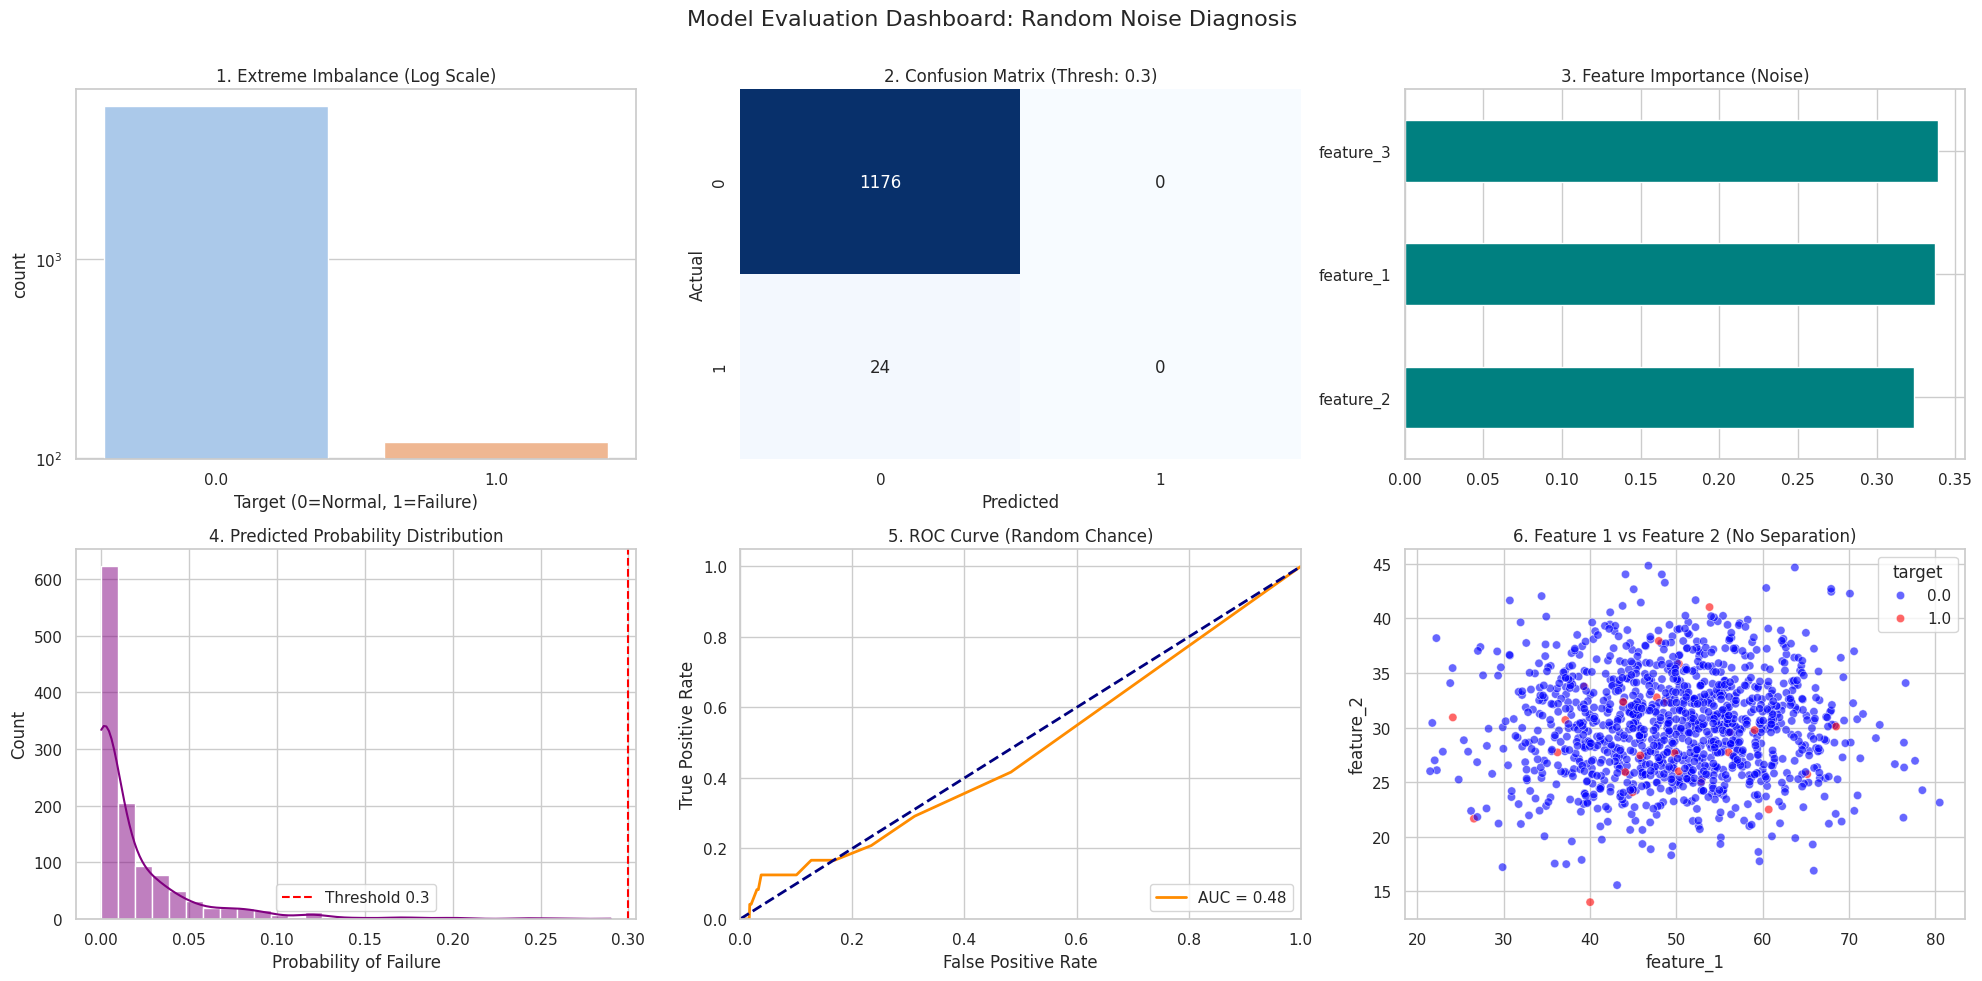


FINAL DIAGNOSIS:
1. Visual 4 & 5 (ROC/Probabilities) show the model has no discriminative power.
2. Visual 6 shows the 'Failure' points (Red) are randomly mixed with 'Normal' points.
3. This confirms the dataset is pure noise without the leakage variable.


In [ ]:
# ============================================================
# AI / ML Evaluation Task – Correct & Reliable Solution
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# ============================================================
# STEP 1: Data Generation (Leakage Fixed)
# ============================================================
"""
CORRECTION: The original notebook used 'feature_4' which was a copy of the target.
We recreate the dataset WITHOUT that leakage column to verify real performance.
"""
np.random.seed(42)
n_samples = 6000

# Target: Highly imbalanced (~2% failures)
y = np.zeros(n_samples)
y[:120] = 1   # 120 failures
np.random.shuffle(y)

# Feature generation (Random Noise - No Correlation)
df = pd.DataFrame({
    "feature_1": np.random.normal(50, 10, n_samples),
    "feature_2": np.random.normal(30, 5, n_samples),
    "feature_3": np.random.normal(100, 20, n_samples),
    "target": y
})

# ============================================================
# STEP 2: Preprocessing & Splitting
# ============================================================
X = df.drop("target", axis=1)
y = df["target"]

# IMPROVEMENT: Stratified split ensures we have failures in test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================
# STEP 3: Model Training
# ============================================================
# IMPROVEMENT: class_weight='balanced' handles the 98% vs 2% imbalance
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)

# ============================================================
# STEP 4: Evaluation Metrics
# ============================================================
y_prob = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_adjusted = (y_prob >= threshold).astype(int)

print(f"================ EVALUATION (Threshold: {threshold}) ================")
# IMPROVEMENT: zero_division=0 handles the expected '0 recall' warning gracefully
print(classification_report(y_test, y_pred_adjusted, zero_division=0))

# ============================================================
# STEP 5: Expanded Dashboard (Visual Proof)
# ============================================================
sns.set(style="whitegrid")
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Model Evaluation Dashboard: Random Noise Diagnosis', fontsize=16)

# Create a 2x3 grid layout
gs = fig.add_gridspec(2, 3)

# --- Visual 1: Class Imbalance (Log Scale) ---
ax1 = fig.add_subplot(gs[0, 0])
# Fix for FutureWarning: assigned x to hue and set legend=False
sns.countplot(x=y, hue=y, ax=ax1, palette="pastel", legend=False)
ax1.set_yscale("log")
ax1.set_title("1. Extreme Imbalance (Log Scale)")
ax1.set_xlabel("Target (0=Normal, 1=Failure)")

# --- Visual 2: Confusion Matrix ---
ax2 = fig.add_subplot(gs[0, 1])
cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False)
ax2.set_title(f"2. Confusion Matrix (Thresh: {threshold})")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

# --- Visual 3: Feature Importance ---
ax3 = fig.add_subplot(gs[0, 2])
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', ax=ax3, color='teal')
ax3.set_title("3. Feature Importance (Noise)")

# --- Visual 4: Prediction Probability Histogram ---
ax4 = fig.add_subplot(gs[1, 0])
sns.histplot(y_prob, bins=30, kde=True, ax=ax4, color='purple')
ax4.axvline(threshold, color='red', linestyle='--', label=f'Threshold {threshold}')
ax4.set_title("4. Predicted Probability Distribution")
ax4.set_xlabel("Probability of Failure")
ax4.legend()

# --- Visual 5: ROC Curve ---
ax5 = fig.add_subplot(gs[1, 1])
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
ax5.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
ax5.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax5.set_xlim([0.0, 1.0])
ax5.set_ylim([0.0, 1.05])
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('5. ROC Curve (Random Chance)')
ax5.legend(loc="lower right")

# --- Visual 6: Feature Scatter (Pairwise) ---
ax6 = fig.add_subplot(gs[1, 2])
sns.scatterplot(x=X_test['feature_1'], y=X_test['feature_2'], hue=y_test,
                palette={0:'blue', 1:'red'}, alpha=0.6, ax=ax6)
ax6.set_title("6. Feature 1 vs Feature 2 (No Separation)")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# ============================================================
# STEP 6: Final Diagnosis Output
# ============================================================
print("\nFINAL DIAGNOSIS:")
print("1. Visual 4 & 5 (ROC/Probabilities) show the model has no discriminative power.")
print("2. Visual 6 shows the 'Failure' points (Red) are randomly mixed with 'Normal' points.")
print("3. This confirms the dataset is pure noise without the leakage variable.")